In [1]:
%matplotlib inline

import copy
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import torch as pt

sys.path.insert(0, '..')

from numpy import exp, log
from scipy.linalg import expm, inv, solve_banded

from function_space import Constant, Linear, DenseNet, NN, NN_Nik, SingleParam
from problems import DoubleWell, DoubleWell_multidim, DoubleWell_OU, LQGC, LLGC, DoubleWell_multidim
from solver import Solver
from utilities import do_importance_sampling, do_importance_sampling_Wei, plot_control_for_DoubleWell1d, plot_loss_logs, plot_solution, save_exp_logs, load_exp_logs

%load_ext autoreload
%autoreload 2

device = pt.device('cuda')

In [2]:
dw = DoubleWell_multidim(name='Double well', d=10, d_1=3, d_2=7, T=1, eta=3, kappa=5)
dw.compute_reference_solution()
dw.compute_reference_solution_2()

In [ ]:
seed = 672

L = 20000
lr = 0.05
delta_t = 0.005
K = 500
IS_K = 50000
print_every = 100

models = [Solver(name='moment', problem=dw, loss_method='moment', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=True,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True),
          Solver(name='log-variance', problem=dw, loss_method='log-variance', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=True,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True),
          Solver(name='relative entropy', problem=dw, loss_method='relative_entropy', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=False,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True),
          Solver(name='cross-entropy', problem=dw, loss_method='cross_entropy', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=True,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True)]

for model in models:
    model.train()

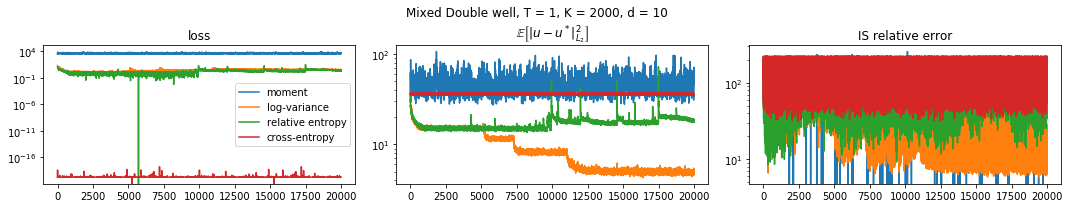

In [38]:
fig = plot_loss_logs('Mixed Double well, T = 1, K = 2000', models) # seed 4211

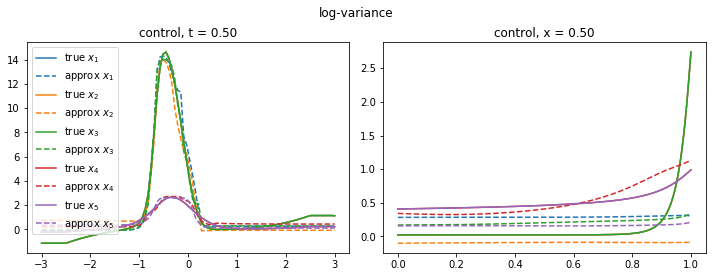

In [39]:
fig = plot_solution(models[1], x=.5, t=0.5, components=[0, 1, 2, 3, 4])

In [42]:
#save_exp_logs(models, 'paper/double_well_d10_d1_3_d2_7')

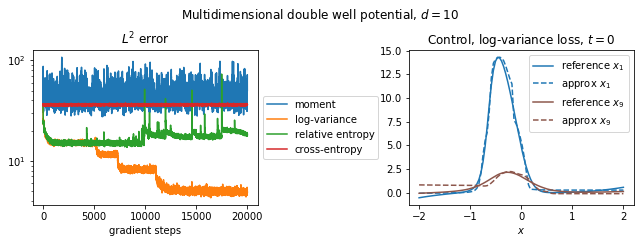

In [64]:
exp_logs = load_exp_logs('paper/double_well_d10_d1_3_d2_7_2020-04-15.json')

COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive',
          'tab:pink', 'tab:gray', 'tab:brown', 'tab:cyan']

ylims = None

model = models[1]
components = [0, 8]

x = -1.0
t = 0
n = int(np.ceil(t / model.delta_t_np))
t_range = np.linspace(0, model.T, model.N)
x_val = pt.linspace(-2, 2, 100)
X = pt.autograd.Variable(x_val.unsqueeze(1).repeat(1, model.d), requires_grad=True).to(model.device)

fig, ax = plt.subplots(1, 2, figsize=(9, 3.5))
fig.suptitle(r'Multidimensional double well potential, $d = 10$')

for model_name in exp_logs:
    ax[0].plot(exp_logs[model_name]['u_L2_loss'], label=model_name)
ax[0].set_yscale('log')
ax[0].set_title('$L^2$ error')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_xlabel('gradient steps')


ax[1].set_title(r'Control, log-variance loss, $t = %.0f$' % t)
for j in components:
    if model.u_true(x_val.unsqueeze(1).repeat(1, model.d), t) is not None:
        ax[1].plot(x_val.numpy(), model.u_true(x_val.unsqueeze(1).repeat(1, model.d), t)[j, :],
                   label=r'reference $x_%d$' % (j + 1), color=COLORS[j])
    ax[1].plot(x_val.numpy(), -model.Z_n(X, t).cpu().detach().numpy()[:, j], '--',

               label=r'approx $x_%d$' % (j + 1), color=COLORS[j])
if ylims is not None:
    ax[1].set_ylim(ylims[0][0], ylims[0][1])
ax[1].legend()
ax[1].set_xlabel(r'$x$')

fig.tight_layout(rect=[0, 0.03, 1, 0.93])
#fig.savefig('img/double_well_d10.pdf')